In [3]:
import pandas as pd

# --- 1. Load all datasets ---
logs = pd.read_csv('/content/drive/MyDrive/LLM4Sec/Week3/apache_logs_labelled.csv')
ip_entropy = pd.read_csv('/content/drive/MyDrive/LLM4Sec/Week3/ip_entropy_features.csv')
geolocation = pd.read_csv('/content/drive/MyDrive/LLM4Sec/Week3/geolocation_enriched.csv')
session_stats = pd.read_csv('/content/drive/MyDrive/LLM4Sec/Week3/session_stats.csv')
# (Optional) Load time-based and sequence features if you wish to merge them:
time_based = pd.read_csv('/content/drive/MyDrive/LLM4Sec/Week3/time_based_features.csv')
sequence_patterns = pd.read_csv('/content/drive/MyDrive/LLM4Sec/Week3/sequence_patterns_features.csv')

# --- 2. Merge IP-based features ---
# Add IP entropy metrics
logs = logs.merge(ip_entropy, on='ip', how='left')

# Add geolocation features (pick only unique IP info, drop duplicates for safe join)
geo_cols = ['ip', 'country_x', 'region', 'city', 'asn', 'reverse_dns']
geo_info = geolocation[geo_cols].drop_duplicates('ip')
logs = logs.merge(geo_info, on='ip', how='left')

# --- 3. Merge Session-level features ---
# Take the most recent session per IP (can change to aggregate if you have session_id per row)
session_latest = session_stats.sort_values('end_time').groupby('ip').tail(1)
session_cols = [col for col in session_stats.columns if col not in ['ip', 'start_time', 'end_time']]
logs = logs.merge(session_latest[['ip'] + session_cols], on='ip', how='left')

# --- 4. (Optional) Merge Time-based/Sequence features if needed ---
# If you want to add time-based, you'll need to round/align timestamps for a good join (not shown here)
# logs = logs.merge(time_based, ...)

# --- 5. Save unified DataFrame for analysis and modeling ---
logs.to_csv('logs_features_unified.csv', index=False)

print("Unified feature set shape:", logs.shape)
print(logs.head())


Unified feature set shape: (37693, 24)
                ip              datetime     gmt  \
0  114.125.221.132  01-Jul 2019 10:54:15  +0700]   
1  114.125.221.132  01-Jul 2019 10:54:23  +0700]   
2  114.125.221.132  01-Jul 2019 10:54:42  +0700]   
3  114.125.221.132  01-Jul 2019 10:55:08  +0700]   
4  114.125.221.132  01-Jul 2019 10:55:28  +0700]   

                                             request  status   size  \
0  GET /bkd_baru/assets/images/scan_sertifikat/D0...   200.0  12133   
1  GET /bkd_baru/assets/images/scan_sertifikat/D0...   200.0  15491   
2  POST /bkd_baru/assets/images/scan_sertifikat/D...   200.0  16305   
3                GET /bkd_baru/uwubahon.php HTTP/1.1   404.0   1130   
4                GET /bkd_baru/awubahon.php HTTP/1.1   200.0   1735   

                                             referer  \
0  http://universitas.com/bkd_baru/assets/images/...   
1  http://universitas.com/bkd_baru/assets/images/...   
2  http://universitas.com/bkd_baru/assets/images/... 

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


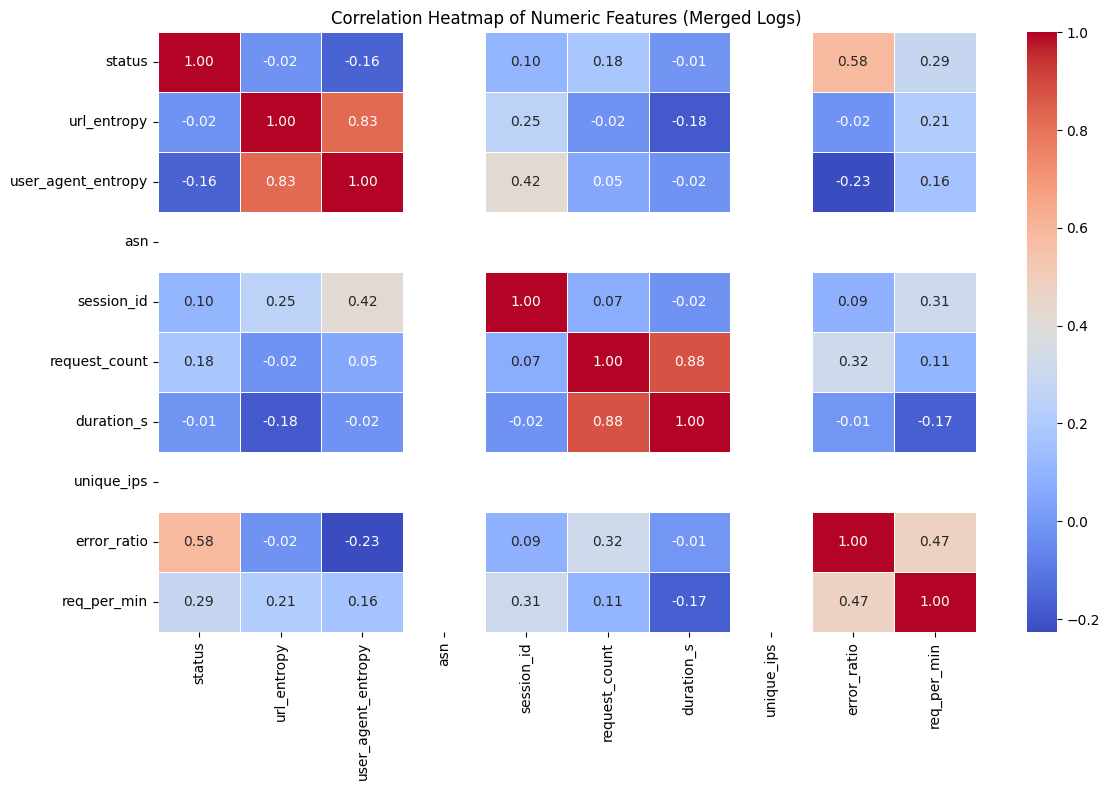

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your merged dataset
logs = pd.read_csv('/content/logs_features_unified.csv')

# Select only numeric columns for correlation
numeric_cols = logs.select_dtypes(include=['number']).columns
corr_matrix = logs[numeric_cols].corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Numeric Features (Merged Logs)')
plt.tight_layout()
plt.show()

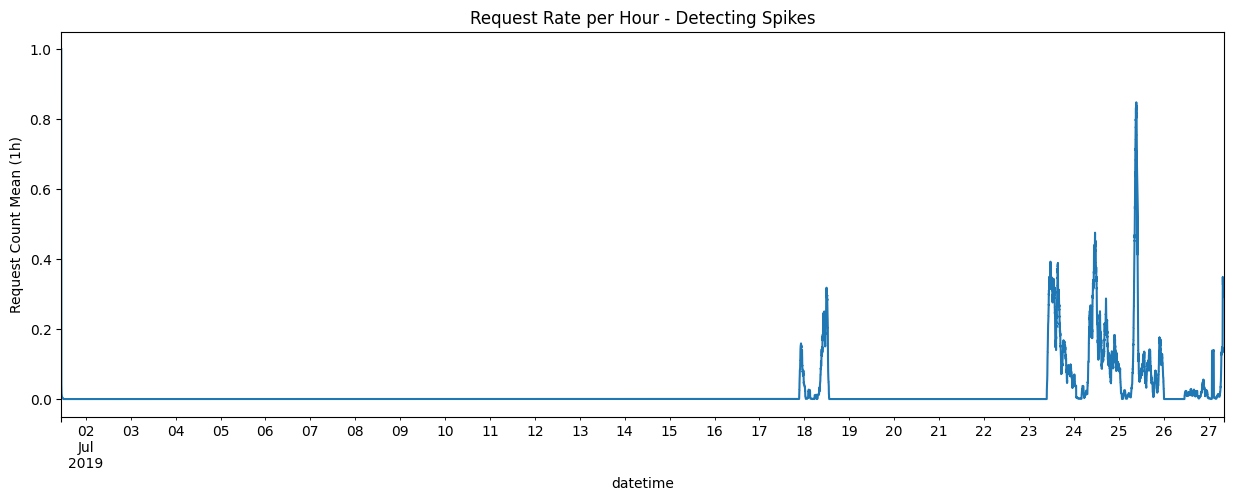

In [6]:
time_based['datetime'] = pd.to_datetime(time_based['datetime'])
time_based.set_index('datetime', inplace=True)

time_based['request_count_mean_1h'].plot(figsize=(15, 5), title='Request Rate per Hour - Detecting Spikes')
plt.ylabel('Request Count Mean (1h)')
plt.show()


In [7]:
logs.columns

Index(['ip', 'datetime', 'gmt', 'request', 'status', 'size', 'referer',
       'browser', 'country', 'detected', 'label', 'url_entropy',
       'user_agent_entropy', 'country_x', 'region', 'city', 'asn',
       'reverse_dns', 'session_id', 'request_count', 'duration_s',
       'unique_ips', 'error_ratio', 'req_per_min'],
      dtype='object')

Cleaning the Data

In [8]:
import pandas as pd

# Load data
session_df = pd.read_csv("/content/drive/MyDrive/LLM4Sec/Week3/session_stats.csv")
entropy_df = pd.read_csv("/content/drive/MyDrive/LLM4Sec/Week3/ip_entropy_features.csv")

# Merge
combined_df = session_df.merge(entropy_df, on="ip", how="left")

# Keep only relevant features
features = ["request_count", "duration_s", "unique_ips", "error_ratio", "req_per_min", "url_entropy", "user_agent_entropy"]
df = combined_df[features]

# Drop rows with missing or non-numeric values
df = df.dropna()
df = df.apply(pd.to_numeric, errors='coerce').dropna()


Pairplot

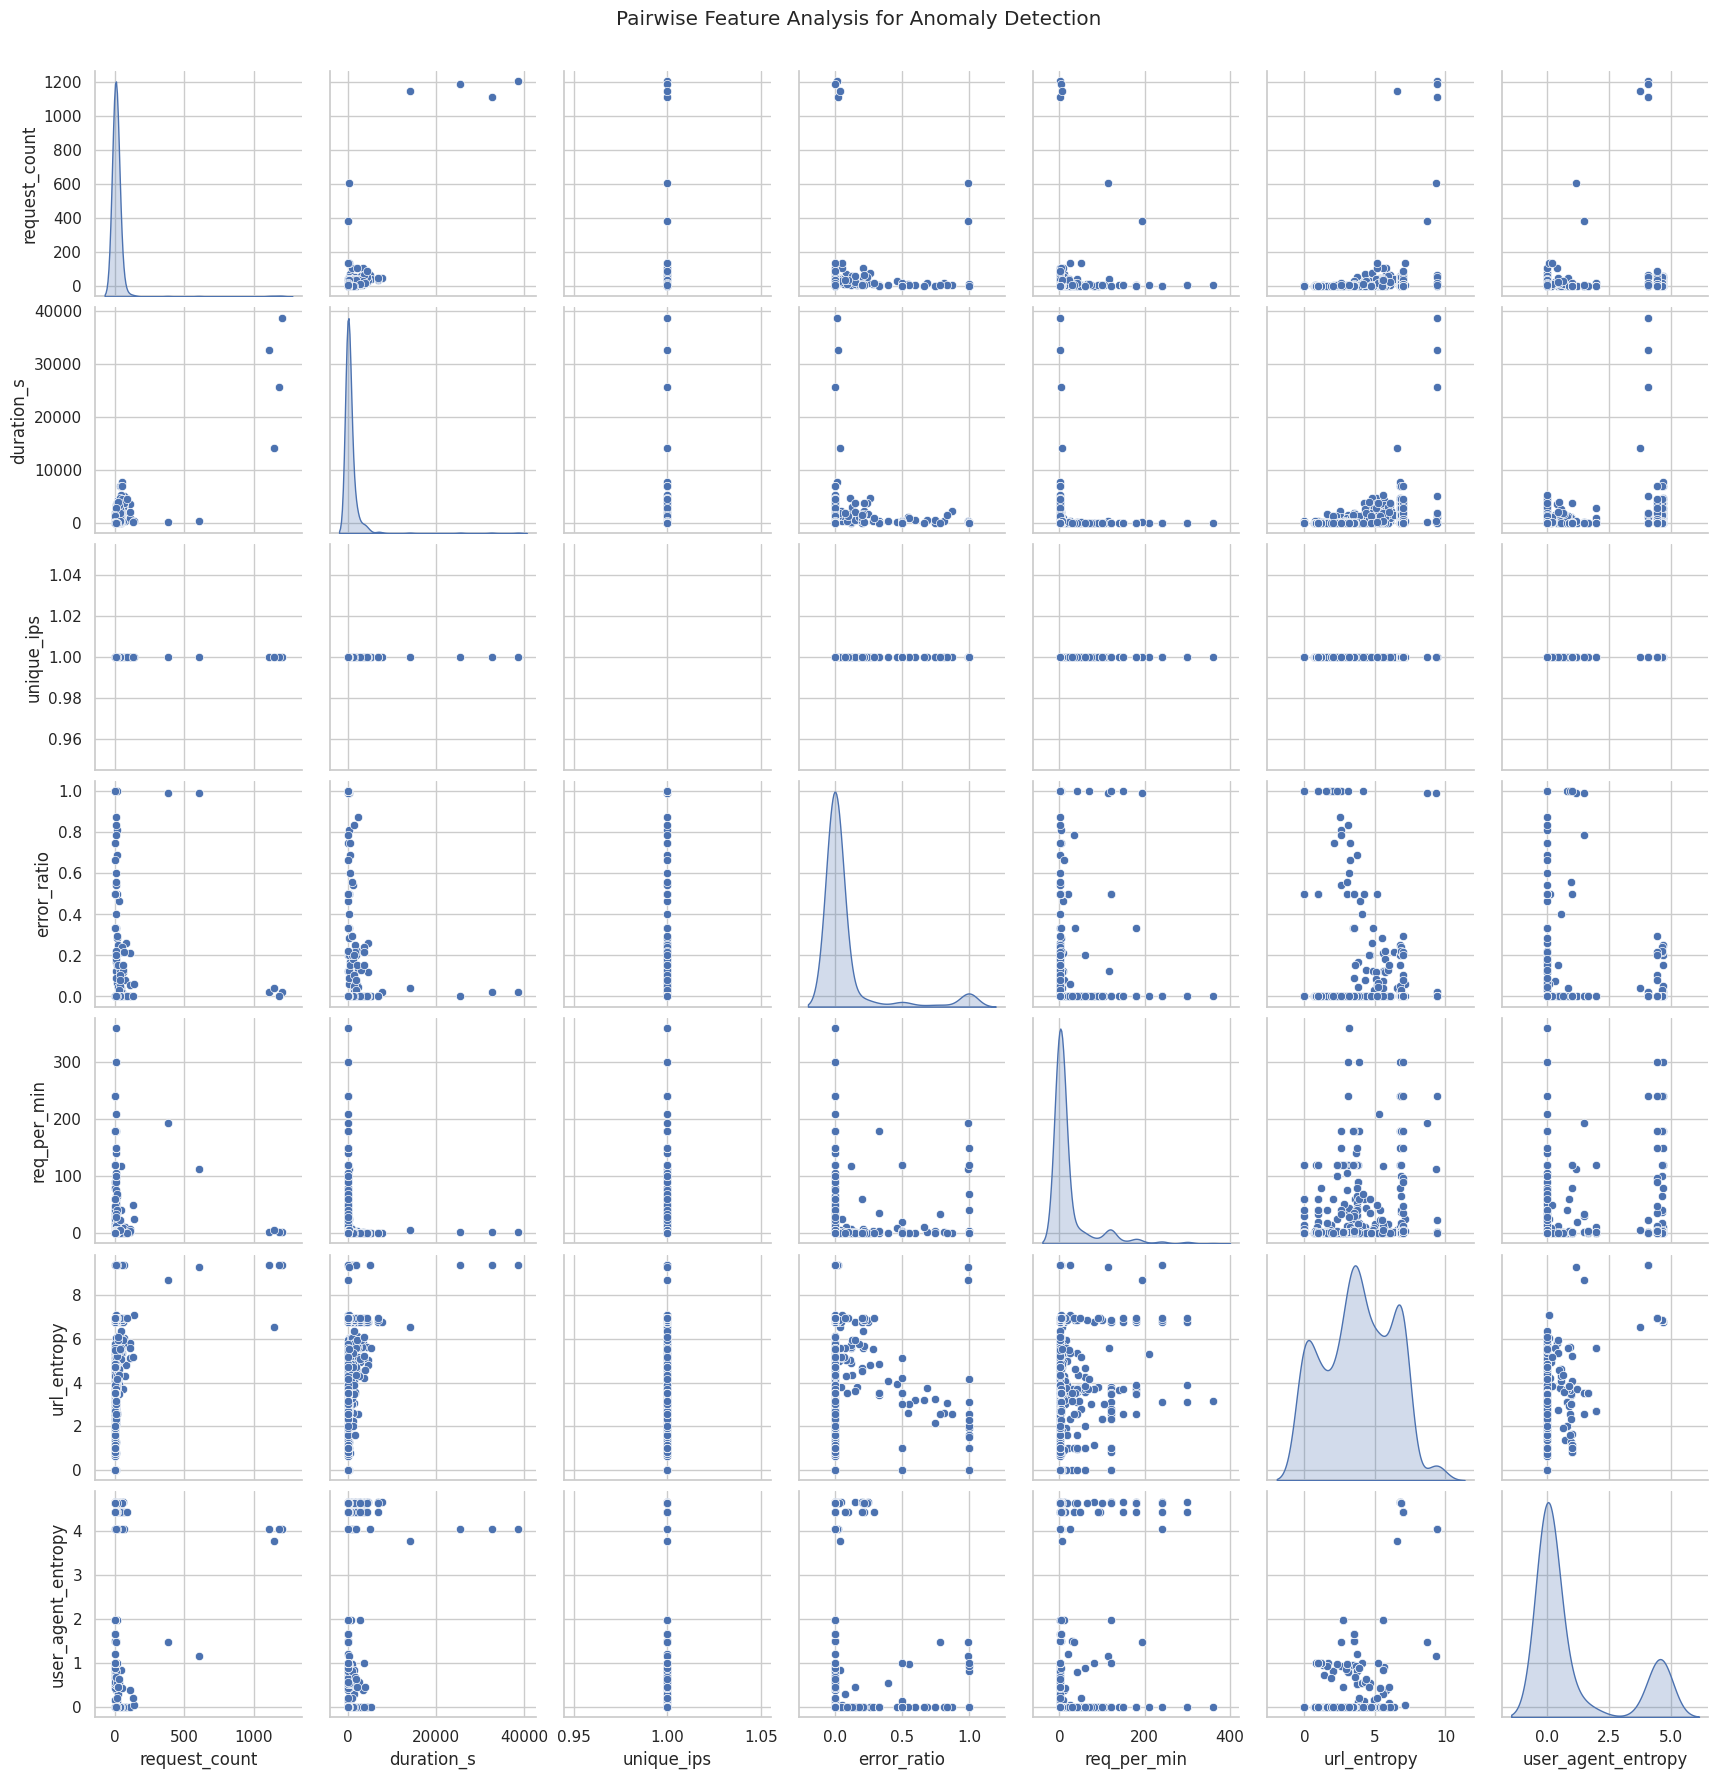

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
sns.pairplot(df, diag_kind="kde")
plt.suptitle("Pairwise Feature Analysis for Anomaly Detection", y=1.02)
plt.show()


Correlation Heatmap

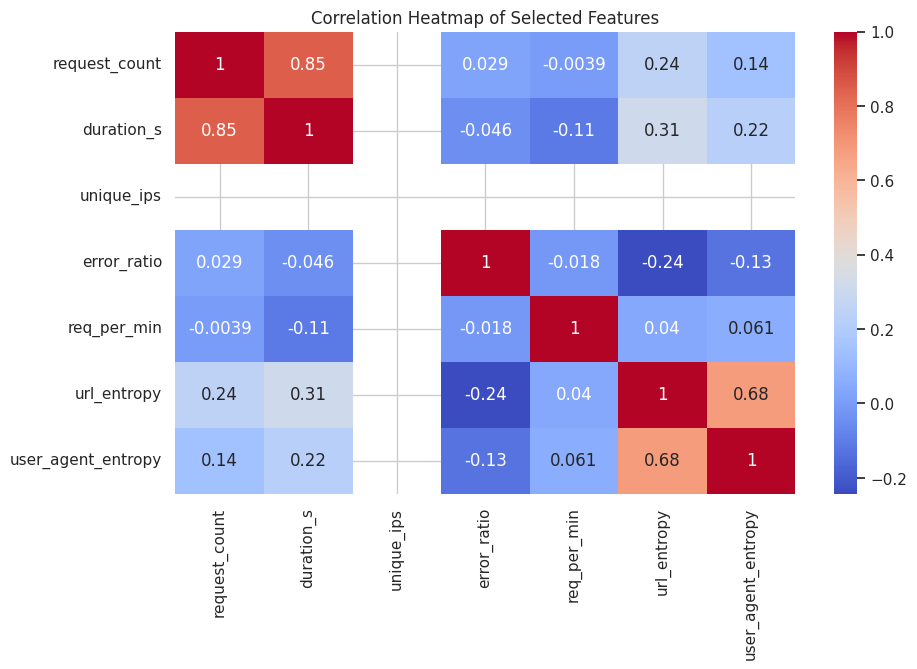

In [10]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap of Selected Features")
plt.show()


Distribution Plots

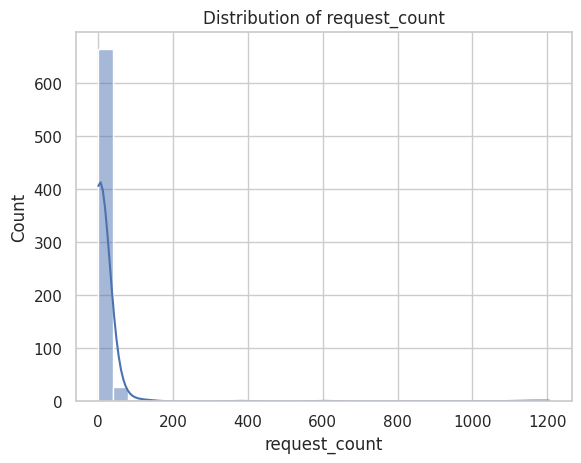

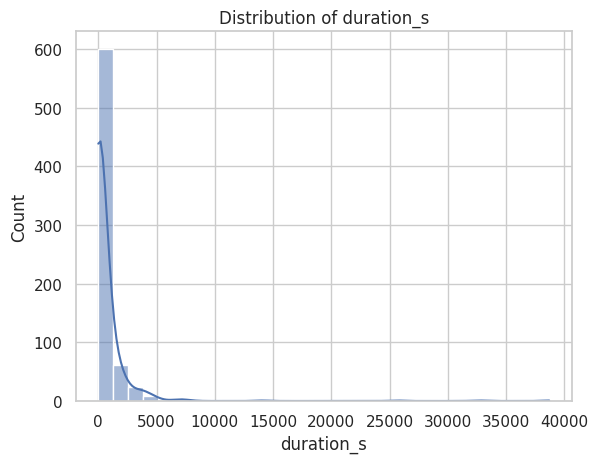

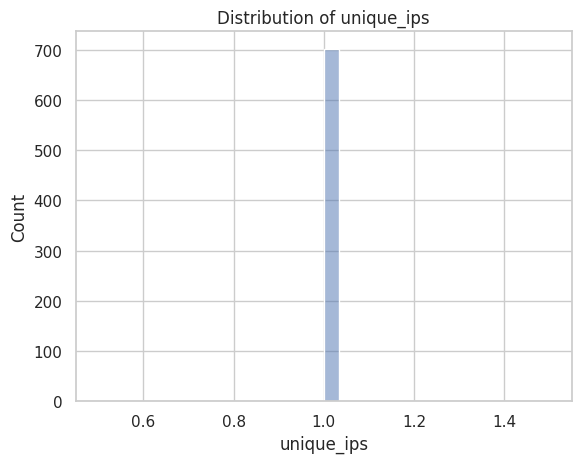

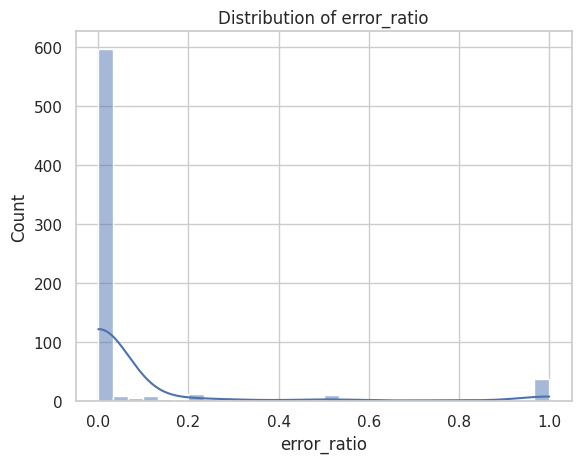

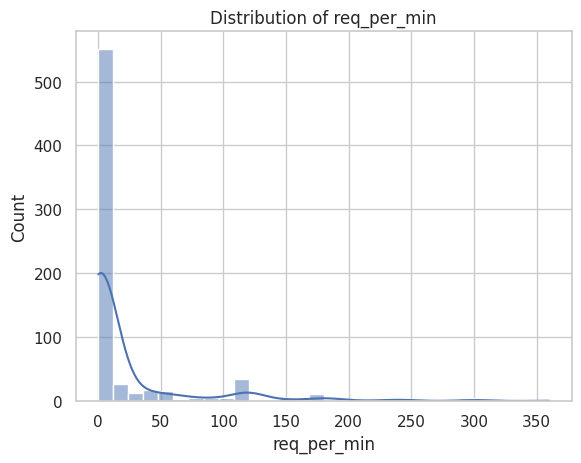

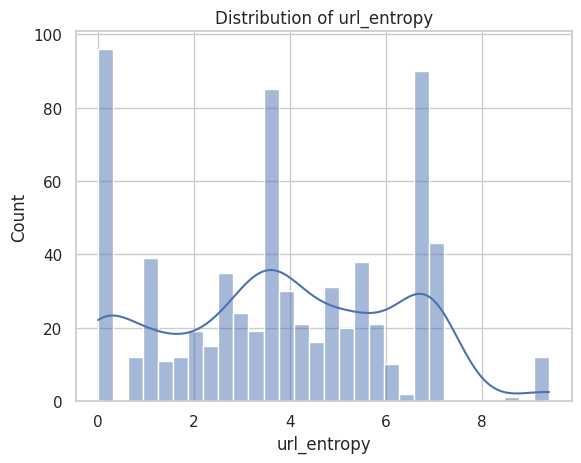

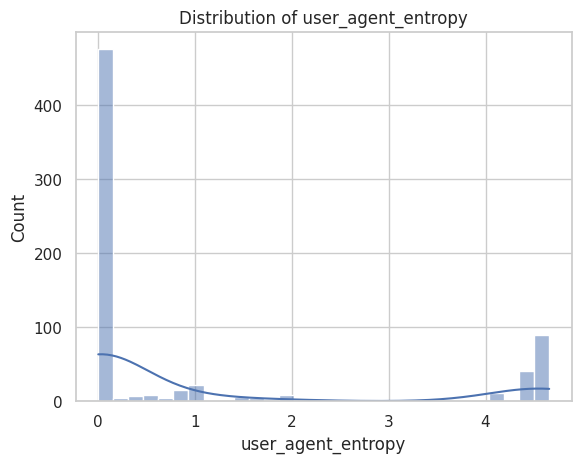

In [11]:
for col in df.columns:
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")
    plt.show()


Prepare data for LSTM

In [12]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Scale data
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df)

# Create sequences
def create_sequences(data, seq_length):
    xs = []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        xs.append(x)
    return np.array(xs)

SEQ_LEN = 10
X = create_sequences(scaled, SEQ_LEN)


Build LSTM Model

In [13]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, TimeDistributed, RepeatVector

model = Sequential()
model.add(LSTM(64, input_shape=(X.shape[1], X.shape[2]), return_sequences=False))
model.add(RepeatVector(X.shape[1]))  # Repeat output to match time steps
model.add(LSTM(64, return_sequences=True))
model.add(TimeDistributed(Dense(X.shape[2])))  # Predict all time steps
model.compile(optimizer='adam', loss='mse')
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 10, 7)          │           455 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,911 (202.78 KB)

 Trainable params: 51,911 (202.78 KB)

 Non-trainable params: 0 (0.00 B)

Train & Detect Anomalies

In [14]:
history = model.fit(X, X, epochs=20, batch_size=64, validation_split=0.1)


Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - loss: 0.0670 - val_loss: 0.0386
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0279 - val_loss: 0.0336
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0223 - val_loss: 0.0316
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0202 - val_loss: 0.0297
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0185 - val_loss: 0.0283
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0174 - val_loss: 0.0271
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0162 - val_loss: 0.0263
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0165 - val_loss: 0.0258
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0152 - val_loss: 0.0255
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0151 - val_loss: 0.0252
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0156 - val_loss: 0.0249
Epoch 12/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


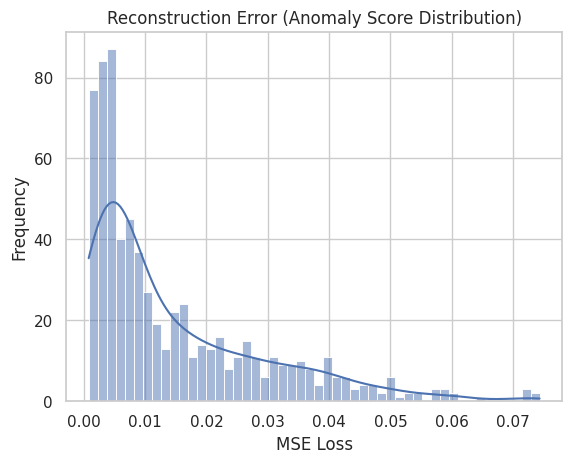

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

X_pred = model.predict(X)
mse = np.mean(np.power(X - X_pred, 2), axis=(1, 2))

sns.histplot(mse, bins=50, kde=True)
plt.title("Reconstruction Error (Anomaly Score Distribution)")
plt.xlabel("MSE Loss")
plt.ylabel("Frequency")
plt.show()


In [16]:
threshold = np.percentile(mse, 95)  # top 5% as anomaly
anomalies = mse > threshold
print(f"Anomalies detected: {np.sum(anomalies)} out of {len(anomalies)} sequences.")


Anomalies detected: 35 out of 692 sequences.


Visualization

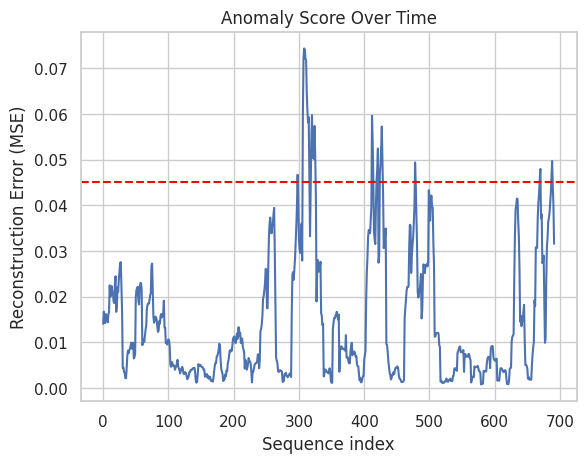

In [17]:
plt.plot(mse)
plt.axhline(threshold, color='red', linestyle='--')
plt.title("Anomaly Score Over Time")
plt.xlabel("Sequence index")
plt.ylabel("Reconstruction Error (MSE)")
plt.show()


Correlation with MSE features

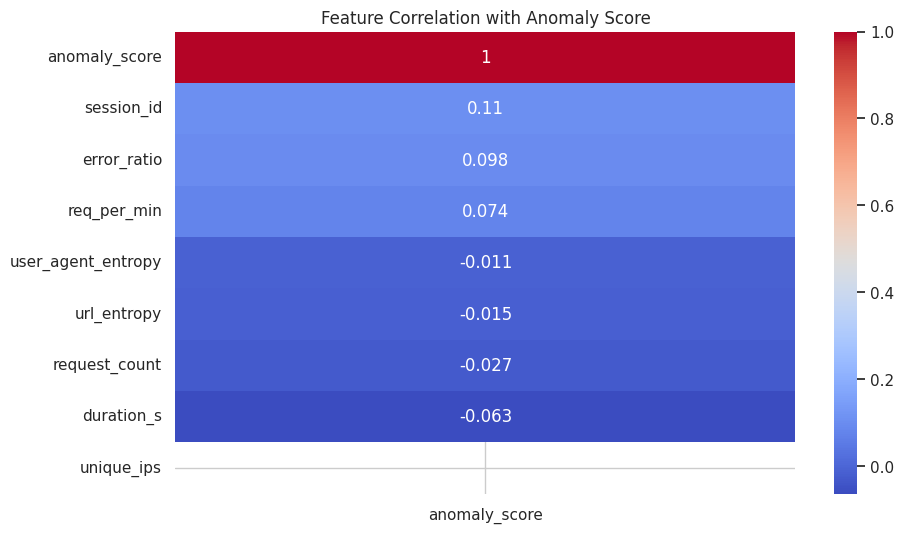

In [18]:
# Create anomaly_scores_df from MSE
anomaly_scores_df = pd.DataFrame({'anomaly_score': mse})
anomaly_scores_df = anomaly_scores_df.iloc[SEQ_LEN:].reset_index(drop=True)

anomaly_scores_df.to_csv("/content/drive/MyDrive/LLM4Sec/Week3/anomaly_scores.csv", index=False)

# Safely join anomaly scores
combined_df_for_analysis = combined_df.iloc[SEQ_LEN:].reset_index(drop=True)
full_df = combined_df_for_analysis.join(anomaly_scores_df)

# Drop non-numeric columns (like 'ip', timestamps, etc.)
numeric_df = full_df.select_dtypes(include='number')

# Compute correlation only on numeric features
correlation = numeric_df.corr()

# Plot correlation with anomaly score
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.heatmap(correlation[['anomaly_score']].sort_values(by='anomaly_score', ascending=False), annot=True, cmap='coolwarm')
plt.title("Feature Correlation with Anomaly Score")
plt.show()


In [19]:
!pip install pyngrok


In [20]:
from pyngrok import ngrok
ngrok.kill()  # ✅ Closes all tunnels


In [22]:
from pyngrok import ngrok, conf

# Paste your token here
authtoken = "2ynvpzO9hx7sertKPpra7QaITwE_3oT6hDWpJc2C6bWhp4zSP"
conf.get_default().auth_token = authtoken


In [23]:
!pip install streamlit pyngrok
from pyngrok import ngrok

public_url = ngrok.connect(8501)
print(f"🌐 Open this Streamlit app URL: {public_url}")

!streamlit run "/content/drive/MyDrive/LLM4Sec/Week3/app1.py" &> /dev/null &

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 105.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 134.4 MB/s eta 0:00:00
🌐 Open this Streamlit app URL: NgrokTunnel: "https://82dec77f5af9.ngrok-free.app" -> "http://localhost:8501"


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/LLM4Sec/Week3/geolocation_enriched.csv")
print("Countries in data:", df['country_x'].unique())
print("Top ASNs:", df['asn'].value_counts().head(10))

Countries in data: ['Indonesia' 'United States' 'Finland' 'Netherlands' 'United Kingdom'
 'Germany' 'Seychelles' 'Japan' 'Russia' 'Ukraine' 'Switzerland' 'Brazil'
 'Turkey' 'China' 'private range' 'Sweden' 'India' 'Singapore' 'Bolivia'
 'Bangladesh' 'Hong Kong' 'Poland' 'France' 'Iran' 'Philippines'
 'South Korea' 'Chile' 'United Arab Emirates' 'Argentina' 'Qatar'
 'Thailand' 'Ecuador' 'Greece' 'Canada' 'Oman']
Top ASNs: Series([], Name: count, dtype: int64)


In [24]:
# Assuming label column is named 'label'
true_labels = session_df['label'].values  # Replace with actual column name if different

# Drop NA or reset if needed
true_labels = pd.Series(true_labels).dropna().astype(int).values

# Align with LSTM sequences
SEQ_LEN = 10
true_labels_trimmed = true_labels[SEQ_LEN:]

# Predicted labels from LSTM
predicted_labels = (mse > threshold).astype(int)

# ✅ Sanity check
print(f"True: {true_labels_trimmed.shape}, Pred: {predicted_labels.shape}")

# Report
from sklearn.metrics import classification_report
print(classification_report(true_labels_trimmed, predicted_labels, target_names=['Normal', 'Anomaly']))


KeyError: 'label'